In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv('ufc_ml_dataset_2024-11-14.csv', parse_dates=['DATE'])
df['year'] = df['DATE'].dt.year

In [3]:
dtypes = df.dtypes.sort_values().to_frame()

# Potential X & y
Quite a few columns were kept in the ML dataset in case they would be useful. But let's start to hone in on the ones we really want to experiment with.

In [4]:
cols_to_drop = [
    'EVENT', 'ROUND', 'DATE', 'DETAILS', 'URL_fight', 'REFEREE', 'BOUT',
    'TIME', 'METHOD', 'OUTCOME', 'FIGHTER_Red', 'TIME FORMAT', 'DOB_Blue',
    'URL_event', 'LOCATION', 'EVENT_DATE', 'DOB_Red', 'FIGHTER', 'FIGHTER_Blue'
]
df = df.drop(columns=cols_to_drop)

In [5]:
text_cols = df.dtypes[df.dtypes == 'object'].index
num_cols = df.dtypes[df.dtypes == 'float64'].index

# Post-2010 only
Prior to the year 2010 the Red victory rate was 100%. This is most likely an artifact of how the data was scraped. In the UFC stats website, older fights always list the winner as the top fighter.

<Axes: xlabel='year'>

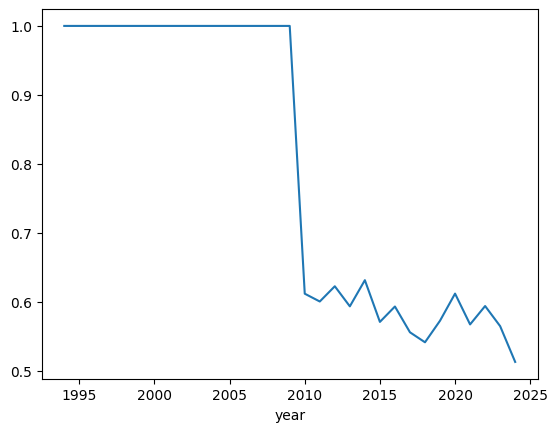

In [6]:
df.groupby('year')['Red_Victory'].mean().plot()

In [7]:
# Remove data prior to 2010
df = df[df['year'] >= 2010]
len(df.index)

6617

# Missingness

## Overall

In [8]:
fig = px.line(
    df.isna().mean().sort_values(ascending=False).to_frame().rename(columns={0: 'Missing Rate'}).reset_index(),
    x='index',
    y='Missing Rate',
    markers=True,
)
fig.update_xaxes(tickfont=dict(size=8))

## By Year

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_missing_by_year = pd.merge(
    df.groupby('year', as_index=False).size().rename(columns={'size': 'Data Points'}),
    df.dropna().groupby('year', as_index=False).size().rename(columns={'size': 'Non-Null'}),
    on='year'
)

df_missing_by_year['Fraction Missing'] = 1 - (df_missing_by_year['Non-Null'] / df_missing_by_year['Data Points'])

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=df_missing_by_year['year'],
        y=df_missing_by_year['Data Points'],
        name='Data Points',
        mode='lines+markers'
    ),
    secondary_y=False,
)

# Add traces
fig.add_trace(
    go.Scatter(
        x=df_missing_by_year['year'],
        y=df_missing_by_year['Fraction Missing'],
        name='Fraction Missing',
        mode='lines+markers'
    ),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="year")

# Set y-axes titles
fig.update_yaxes(title_text="Data Points", secondary_y=False)
fig.update_yaxes(title_text="Fraction Missing", secondary_y=True)

fig.show()


# EDA

# Unknown fighters

In [10]:
pd.crosstab(df['Red_Unknown'], df['Blue_Unknown'], normalize=True)

Blue_Unknown,0.0,1.0
Red_Unknown,,
0.0,0.772102,0.142663
1.0,0.035515,0.049720


## Correlations

<Axes: >

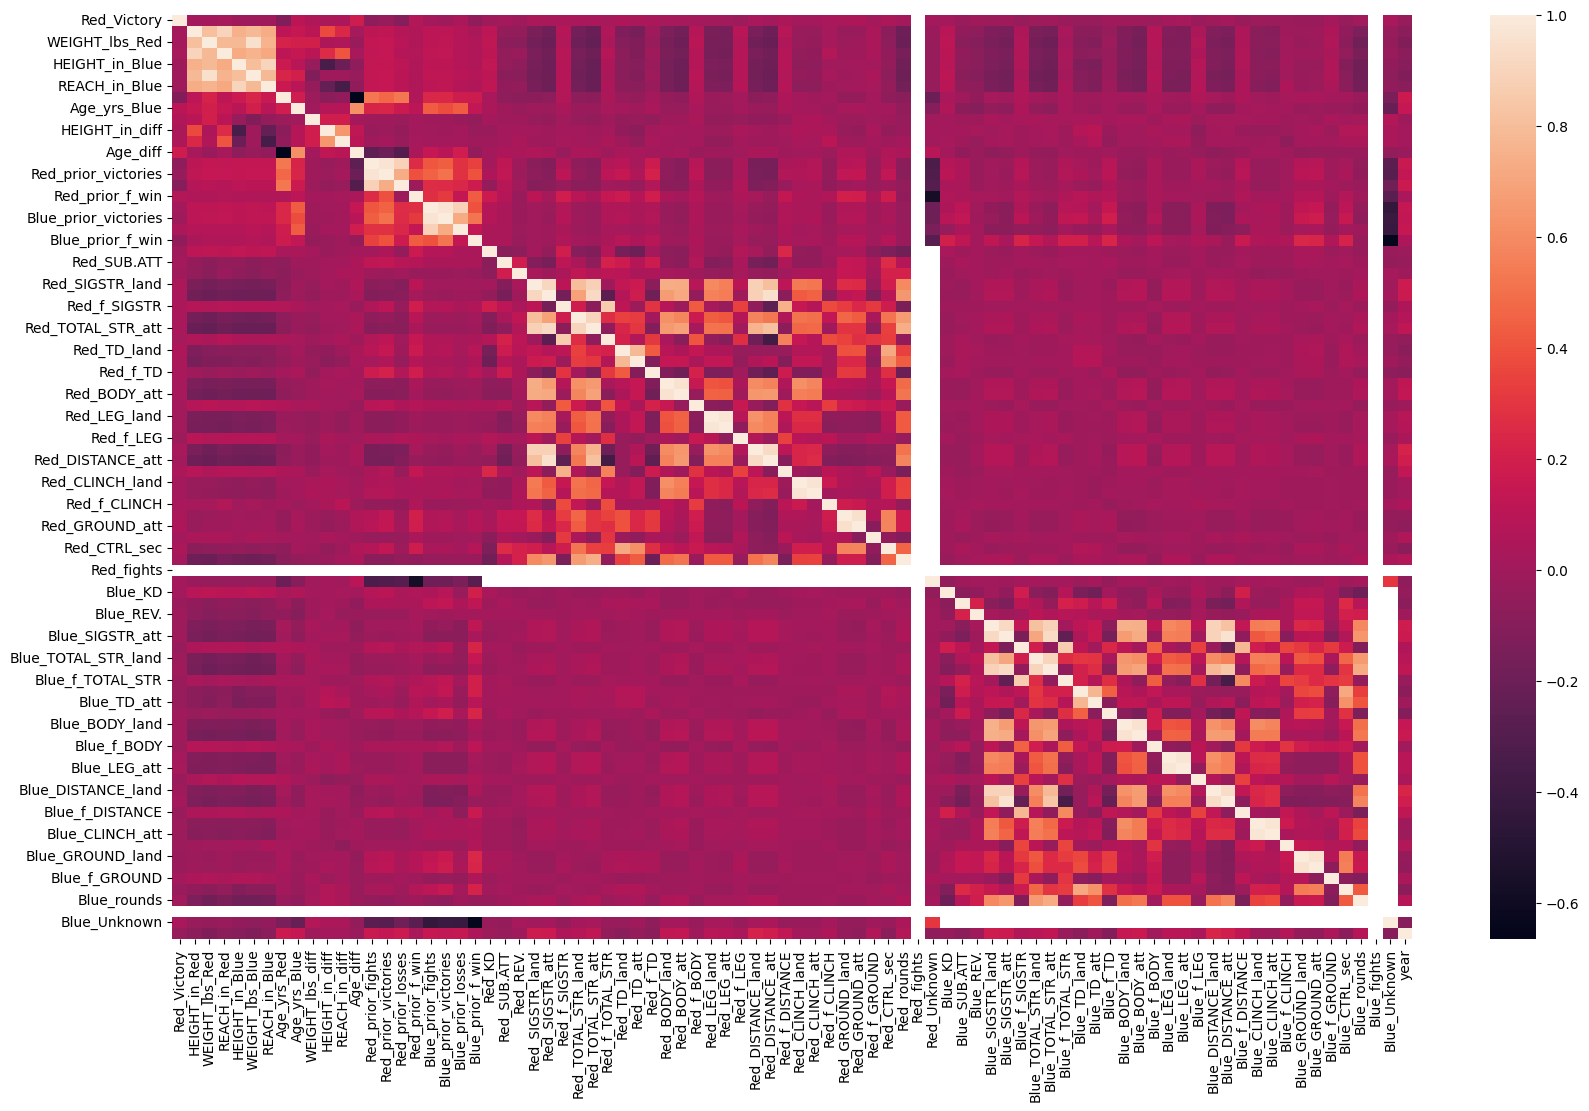

In [11]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.select_dtypes('number').corr())

## Univariate Analysis

### Event Rates

In [12]:
def event_rate(df_: pd.DataFrame, x_col: str, y_col: str, bins=10):

    df_ = df[[x_col, y_col]]

    x_col_binned = f'{x_col}_binned'
    df_[x_col_binned] = pd.cut(df_[x_col], bins=bins).apply(lambda x: f'{x.left} to {x.right}')

    df_event_rate = df_.groupby(x_col_binned, as_index=False).agg(
        event_rate = (y_col, 'mean'),
        data_count = (y_col, 'size')
    )

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(
            x=df_event_rate[x_col_binned],
            y=df_event_rate['event_rate'],
            name='Event Rate',
            mode='lines+markers'
        ),
        secondary_y=False
    )

    # Add traces
    fig.add_trace(
        go.Bar(
            x=df_event_rate[x_col_binned],
            y=df_event_rate['data_count'],
            name='Data Count',
            # mode='lines+markers'
        ),
        secondary_y=True,
    )

    # fig.data = fig.data[::-1]

    # Set x-axis title
    fig.update_xaxes(title_text=x_col_binned)

    # Set y-axes titles
    fig.update_yaxes(title_text="Event Rate", secondary_y=False)
    fig.update_yaxes(title_text="Data Count", secondary_y=True)
    fig.update_layout(title=x_col_binned)

    return df_event_rate, fig
    # return df_

In [13]:
numeric_features = df.dtypes[df.dtypes == 'float64'][1:].index

for col in numeric_features:
    # print(col)
    event_rate(df, col, 'Red_Victory', bins=5)[1].show()

### Information Value
Information value can be a good method for anticipating the univariate predictive power of a feature. While we can derive the multivariate importances using outputs of the ML models themselves, I find it valuable to understand my features before dumping them into a model.

A good primer on information value can be found [here](https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/), and I lifted the IV calculation function below from [here](https://medium.com/@srishtisawla/understanding-information-value-iv-in-machine-learning-5a2f147d6d3e) 

In [27]:
import pandas as pd
import numpy as np

def calculate_iv(df, feature, target):
    """
    Calculate the information value (IV) of a feature in a dataset.
    
    Parameters:
    df (pandas.DataFrame): the dataset
    feature (str): the name of the feature to calculate IV for
    target (str): the name of the target variable
    
    Returns:
    float: the information value (IV) of the feature
    """
    df = df[[feature, target]]
    df = df.dropna()
    n = df.shape[0]
    good = df[target].sum()
    bad = n - good
    unique_values = df[feature].unique()
    iv = 0
    for value in unique_values:
        n1 = df[df[feature] == value].shape[0]
        good1 = df[(df[feature] == value) & (df[target] == 1)].shape[0]
        bad1 = n1 - good1
        if good1 == 0 or bad1 == 0:
            continue
        woe = np.log((good1 / good) / (bad1 / bad))
        iv += (good1 / good - bad1 / bad) * woe
    return iv

From [this stack overflow article](https://stackoverflow.com/questions/60892714/how-to-get-the-weight-of-evidence-woe-and-information-value-iv-in-python-pan)

In [28]:
def calculate_iv2(df, feature, target):
    df_woe_iv = (pd.crosstab(df[feature],df[target],
                        normalize='columns')
                .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
                .assign(iv=lambda dfx: np.sum(dfx['woe']*
                                            (dfx[1]-dfx[0]))))

    return df_woe_iv

In [16]:
ivs = {}
for col in numeric_features:
    # print(col, ': ', calculate_iv(df, col, 'Red_Victory'))
    ivs[col] = {'iv': calculate_iv(df, col, 'Red_Victory')}

fig = px.bar(
    pd.DataFrame.from_dict(ivs).T.sort_values('iv', ascending=False).reset_index(),
    x='index', y='iv'
)
fig.update_xaxes(tickfont=dict(size=8))

# Basic modeling

## Remaining NA
This can be revisited. For now we want to move onto modeling so dropping rows with any missing values for the features of interest

### Option 1 - drop

In [17]:

print(len(df.index))
df1 = df.dropna()
print(len(df1.index))


6617
768


### Option 2 - Impute

In [18]:
df2 = df.copy()

# Impute 'fraction' columns with 0
df2[df2.columns[df2.columns.str.contains('f_')]].fillna(0)

# Fill each column's NaN values with its median
df2.fillna(df2.select_dtypes(include='number').median(), inplace=True)

In [19]:
# Only model fights with known fighters
# df = df[(df['Red_Unknown'] == 0) & (df['Blue_Unknown'] == 0)]

In [20]:
# df_model = df1.copy()
df_model = df2.copy()


# Create one-hot df
df_model = pd.get_dummies(df_model)
df_model.shape

(6617, 187)

In [21]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['Red_Victory'])
y = df_model['Red_Victory']


## LR

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.6187311178247734

In [23]:
df.Red_Victory.mean()

np.float64(0.5813953488372093)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.6187311178247734

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.34      0.42       667
         1.0       0.64      0.81      0.72       988

    accuracy                           0.62      1655
   macro avg       0.59      0.57      0.57      1655
weighted avg       0.60      0.62      0.60      1655

[[226 441]
 [190 798]]


## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

clf = DecisionTreeClassifier()

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3)

# Train the model
clf = clf.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.34      0.42       667
         1.0       0.64      0.81      0.72       988

    accuracy                           0.62      1655
   macro avg       0.59      0.57      0.57      1655
weighted avg       0.60      0.62      0.60      1655

[[226 441]
 [190 798]]


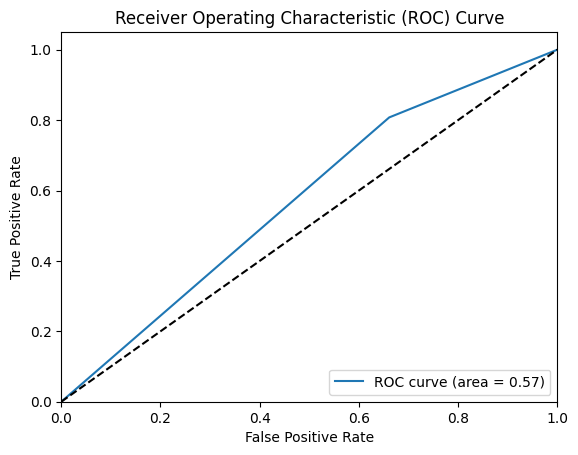

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

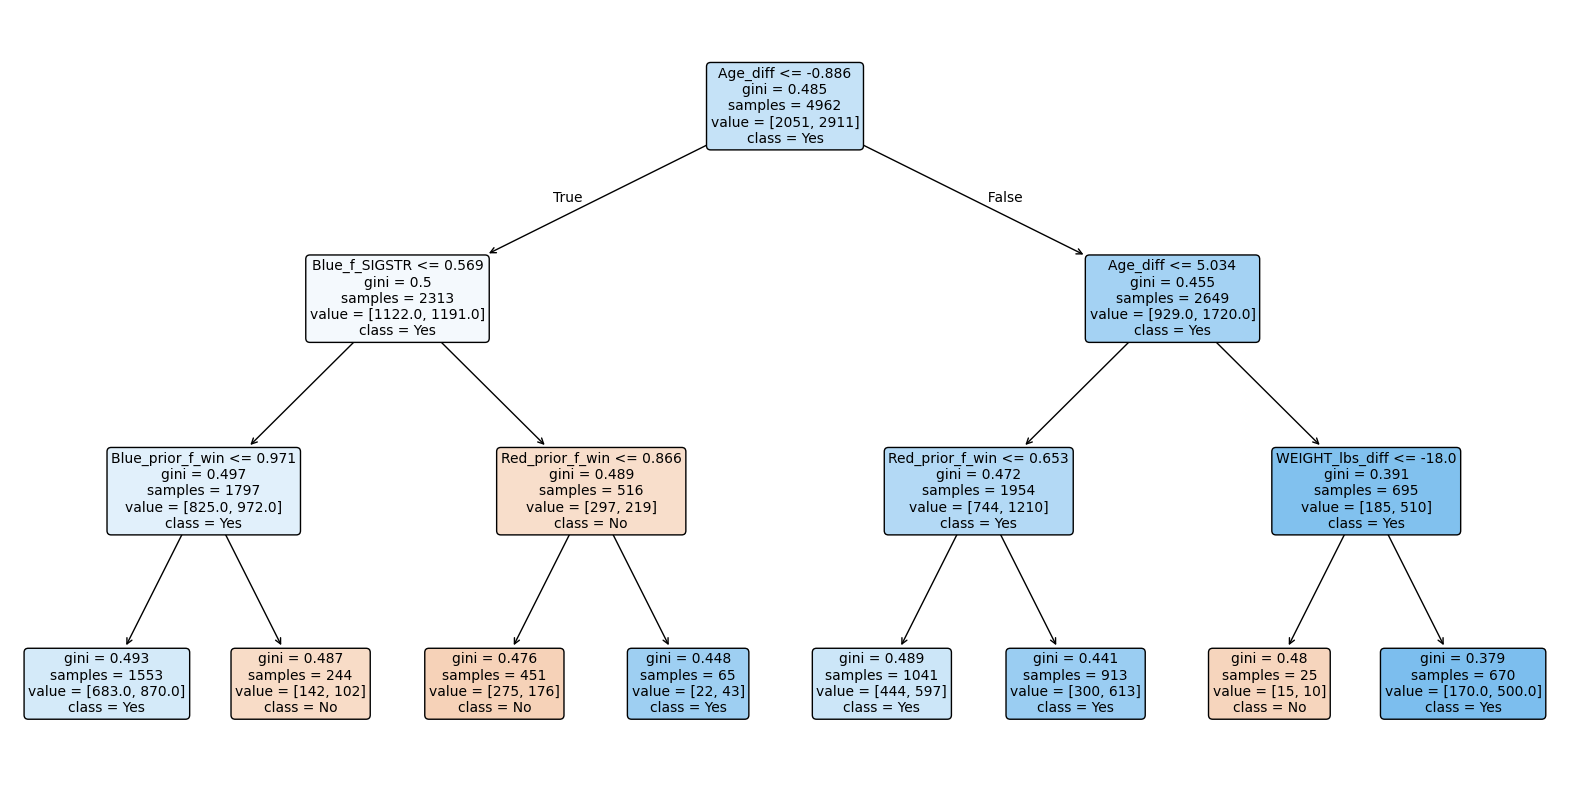

In [30]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, rounded=True, class_names=['No', 'Yes'], feature_names=X.columns)
plt.show()

## RF

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#  Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

rf.feature_importances_

Accuracy: 0.6


array([1.25472454e-02, 1.03071923e-02, 1.60514526e-02, 1.49530280e-02,
       9.94852481e-03, 1.61163748e-02, 2.98514757e-02, 2.98623398e-02,
       1.12505009e-02, 1.48787191e-02, 1.86220120e-02, 3.50000028e-02,
       1.40034370e-02, 1.19245534e-02, 1.13968872e-02, 1.77183304e-02,
       1.10377686e-02, 9.53399638e-03, 8.05726766e-03, 1.18007263e-02,
       3.06789094e-03, 4.58630779e-03, 2.40174364e-03, 1.50642952e-02,
       1.50173261e-02, 1.74447307e-02, 1.51177884e-02, 1.50213198e-02,
       1.54312258e-02, 6.06076854e-03, 8.91943289e-03, 8.18803605e-03,
       1.01790565e-02, 1.18800633e-02, 1.18847815e-02, 9.36473657e-03,
       9.89624837e-03, 1.09703802e-02, 1.30438081e-02, 1.39382784e-02,
       1.67965870e-02, 1.02470013e-02, 1.10699432e-02, 1.15343801e-02,
       8.62345405e-03, 1.10124827e-02, 1.20181164e-02, 1.54992851e-02,
       2.98184129e-03, 0.00000000e+00, 5.10698114e-04, 2.35143832e-03,
       3.87838044e-03, 2.15892451e-03, 1.17672504e-02, 1.31175666e-02,
      

In [33]:
X.shape[1]

186

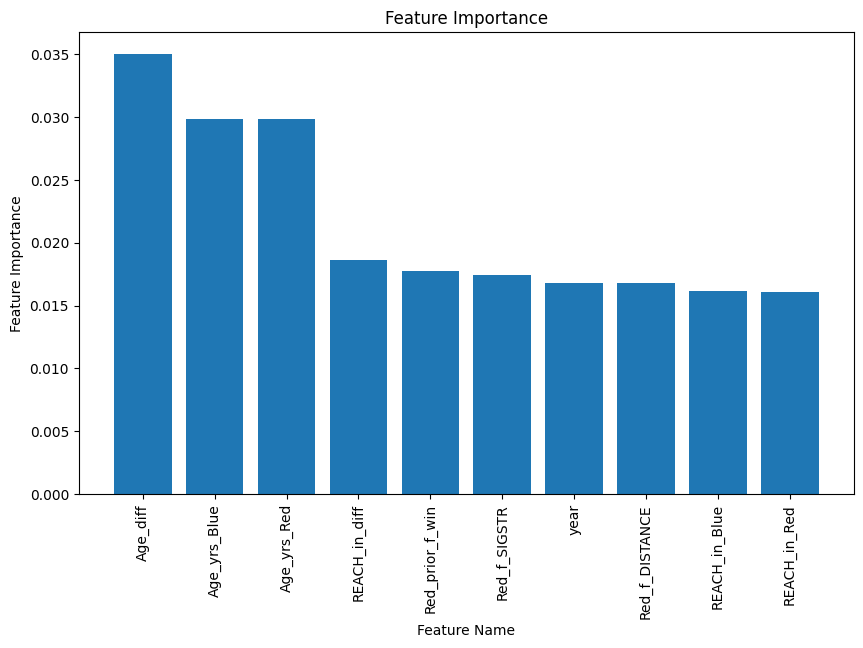

In [34]:
import numpy as np

# Get feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
# plt.bar(range(X.shape[1]), importances[indices])
plt.bar(range(10), importances[indices][:10])
# plt.xticks(range(X.shape[1]), names, rotation=90)
plt.xticks(range(10), names[:10], rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
plt.show()

# Tuning & SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris

# Define the parameter grid for the SVM model
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Create an SVM model
model = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)